In [1]:
from transformers import GPT2Config, GPT2LMHeadModel, GPT2TokenizerFast, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from pathlib import Path
import wandb
import os
import json

In [2]:
wandb.login()

wandb: Currently logged in as: macosta (use `wandb login --relogin` to force relogin)


True

In [2]:
TOKENIZER_SAVEDIR = Path('/home/macosta/ttmp/primus-data/blocks/blocks-v3-tokenizer/')
LM_MODEL_SAVEDIR = Path('/home/macosta/ttmp/primus-models/gpt2-lm-blocks-nocols/')
Path(LM_MODEL_SAVEDIR).mkdir(exist_ok=True)
TXT_FILES = Path('/home/ibukey/ttmp/blocks-txt-v3/')

In [35]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

[<torch.cuda.device at 0x7f4b0084c290>, <torch.cuda.device at 0x7f4b0084c8d0>]

In [36]:
torch.cuda.set_device(0)
print('Cuda available: ', torch.cuda.is_available())

Cuda available:  True


In [5]:
torch.cuda.current_device()

0

In [3]:
VOCAB_SIZE = 30000
MAX_LEN = 512
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_SAVEDIR, max_len=MAX_LEN)

file /home/macosta/ttmp/primus-data/blocks/blocks-v3-tokenizer/config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
list(tokenizer.vocab.items())[:5]

[('000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000111011100000111111011111111111111011111111111111011111111111111011111111111111011111111111111011111111111111011111111111111',
  430),
 ('000000001111111000000000111111000000000111111000000000111111000000000011111000000000111111000000000111111000000000111111000000001111111000000001111111000000011111111000000111111111000001111111111000011111111111001111111111111',
  12901),
 ('111111111111111111111111111100111111111111000111111111111000111111111110000111111111110000111111111100000111111111100000111111111100000111111111100000111111111100000111111111100000111111111100000111111111110000111111111111000',
  5581),
 ('000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111000111111111111111111111111111111111111111111111000000001111111000000000000000000000000000000000000000000000000000000000000',
  21154),
 ('100000000000011100000000000001100000

In [39]:
for item in tokenizer.vocab:
    if item[0] != '<':
        assert(len(item) == 15 * 15)

In [4]:
tokenizer.unk_token = '<unk>'
tokenizer.bos_token = '<s>'
tokenizer.eos_token = '</s>'
tokenizer.add_special_tokens({'pad_token': '<pad>'})

0

In [41]:
ACTUAL_VOCAB_SIZE = len(tokenizer.vocab)

In [42]:
ACTUAL_VOCAB_SIZE

30001

In [95]:
config = GPT2Config(
    vocab_size=ACTUAL_VOCAB_SIZE,
    n_positions=MAX_LEN,
    n_head=12,
)

model = GPT2LMHeadModel(config=config)
print('Num parameters:', model.num_parameters())

Num parameters: 108489984


In [5]:
class CustomDataset(Dataset):
    def __init__(self, src_files, tokenizer, max_length):
        self.examples = []
        for src_file in tqdm(src_files):
            words = src_file.read_text(encoding="utf-8")
            words = words.split()
            words = ['<s>'] + words + ['</s>']
            for i in range(0, len(words), max_length):
                word_string = ' '.join(words[i:i+max_length])
                tokenized = tokenizer.encode(word_string, max_length=max_length, padding='max_length')
                assert(len(tokenized) == max_length)
                self.examples.append(tokenized)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i])

In [6]:
def create_train_test_datasets(tokenizer, max_length, fraction=1.0, test_size=0.1):
    src_files = list(Path(TXT_FILES).glob("**/*.txt"))
    src_files = src_files[:int(len(src_files) * fraction)]
    split_index = int(len(src_files) * (1 - test_size))
    train_files = src_files[:split_index]
    test_files = src_files[split_index:]
    train_dataset = CustomDataset(train_files, tokenizer, max_length=max_length)
    test_dataset = CustomDataset(test_files, tokenizer, max_length=max_length)
    return train_dataset, test_dataset

In [7]:
train_dataset, test_dataset = create_train_test_datasets(tokenizer, MAX_LEN, fraction=.01, test_size=0.05)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 86.74it/s]


In [8]:
import numpy as np
from math import ceil
from PIL import Image

In [102]:
UNK_TOKEN = np.array([0 if i % 2 else 1 for i in range(225)], dtype=np.uint8).reshape((15, 15)) * 255

In [103]:
def tokens_to_image(tokens):
    tokens = [t for t in tokens if t not in ["<s>", "</s>", "<pad>"]]
    img_array = np.ones((15 * 6 + 5 * 3, ceil(len(tokens) / 6)*15), dtype=np.uint8) * 255
    for i in range(5):
        img_array[i*18+15:(i*18)+3+15, :] = 0
    for i, token in enumerate(tokens):
        if token == '<unk>':
            token_np = UNK_TOKEN
        else:
            token_np = np.array([int(x) for x in token]).reshape((15, 15))
            token_np = token_np * 255
        row = i % 6
        column = i // 6
        start_row = row * 18
        start_column = column * 15
        img_array[start_row:start_row+15, start_column:start_column+15] = token_np
        img = Image.fromarray(img_array)
    return img

In [11]:
train_dataset.__getitem__(1)

tensor([    0,     4,     4,    49,    57,   121,     4,    93,    89,    88,
           58,   172,    74,    73,    65,    66,   171,   129,    63,    75,
           37,     4,    59,    64,     4,     4,   191,     6,   184,     4,
            4,     4,     4,   292,   190,     4,     4,    11,   516,   380,
            4,     4,     4,     4,   398,     4,     4,     4,     4,     4,
            4,  2453,  3290,     4,     4,     4,     4,  3002,  2452,     4,
            4,     4,     4,  2267,  1650,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,   877,     4,     4,     4,     4,     4,  1758,
            4,     4, 10411,    11,    11,  4956,     4,     4,   392, 17272,
        16597,     4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,     4,    24,    24,    24,    24,     4,     4, 

In [104]:
# decoded = tokenizer.decode(train_dataset.__getitem__(2)).split()

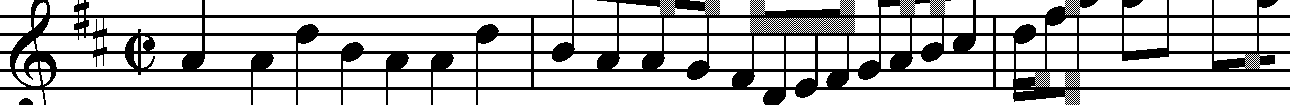

In [105]:
# tokens_to_image(decoded)

In [23]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [41]:
N_EPOCHS = 5
BATCH_SIZE = 8
N_EVALS = 20

In [39]:
N_STEPS = len(train_dataset) * N_EPOCHS // BATCH_SIZE

In [34]:
STEPS_PER_EVAL = N_STEPS // N_EVALS

In [36]:
training_args = TrainingArguments(
    output_dir=LM_MODEL_SAVEDIR,
    overwrite_output_dir=True,
    num_train_epochs=N_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    logging_steps=STEPS_PER_EVAL,
    evaluation_strategy="steps",
    eval_steps=STEPS_PER_EVAL,
    save_total_limit=1,
    prediction_loss_only=False,
    report_to="wandb",
    save_steps=5000
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [37]:
ret = trainer.train()

/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2531
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: macosta (use `wandb login --relogin` to force relogin)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 1440, in forward
    return_dict=return_dict,
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 897, in forward
    output_attentions=output_attentions,
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 401, in forward
    output_attentions=output_attentions,
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 336, in forward
    attn_output, attn_weights = self._attn(query, key, value, attention_mask, head_mask)
  File "/home/macosta/anaconda3/envs/mir2/lib/python3.7/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 196, in _attn
    attn_weights = attn_weights / (float(value.size(-1)) ** 0.5)
RuntimeError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 23.70 GiB total capacity; 11.96 GiB already allocated; 230.56 MiB free; 12.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
trainer.save_model(LM_MODEL_SAVEDIR)